In [42]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


from Utils import evaluation_measures as ev
#import dataframe_image as dfi
import scipy.stats as stats

In [43]:
data_directory_in_str = '/mnt/c/Users/Yassin/Desktop/Code/Backbones Survey 2022/Backbone Results/All/'
network_names = {'aagregated_subjects': 'Human Connectome','academia': 'Faculty Hiring US','airports': 'Worldwide Air Transportation','all_1m': 'Budapest Connectome 3','facebook-like-forum': 'Facebook Like Forum','foodweb_baywet': 'Florida Bay','game_thrones': 'Game of Thrones','gene interactions': 'Gene Interactions','hermaphrodite_gap_junction': 'C. elegans','highschool': 'Illinois High School','job_mobility_network_09_10': 'Job Mobility','karate_club': 'Karate Club','lesmis': 'Les Misérables','meetup-comembership': 'Meetup Dublin','messal_shale': 'Messel Shale','openflights': 'Openflights','paris_bus': 'Paris Bus','paris_rail': 'Paris Rail','residence_hall': 'ANU Residence Hall','salanthe-high-school': 'US-HS','shipping-2015': 'GLSN 2015','sociopatterns-conference': 'It-SC','sociopatterns-high-school': 'Fr-HS','sociopatterns-hospital': 'Fr-Ho','sociopatterns-primary-school': 'Fr-PS','sociopatterns-workplace': 'Fr-Wo','southern_club_women': 'Southern Women Club','sports_cotagging': 'Sports Cotagging','toth-elementary-school': 'US-ES','toth-middle-school': 'US-MS','train_terrorists': 'Madrid Train Bombing','us-airports-500': 'US Airports 500','webkb_cornell_cocite': 'Webkb Cornell','webkb_washington_cocite': 'Webkb Washington','windsurfers': 'Windsurfers','youtube-2': 'Youtube-SF','youtube-3': 'Youtube-SSP','youtube-4': 'Youtube-SSB','youtube-5': 'Youtube-SFV'}

In [44]:
a = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# a1 = a*10**-3
a2 = a*10**-2
a3 = a*10**-1
a4 = a*10**0
a5 = [1]

significane_levels = np.concatenate((a2, a3, a4, a5), axis=None)
properties = ['LCC Size', '% Isolated Nodes', '% Edges', '% Weights']
names = ['mlf_score', 'nc_alpha', 'ecm_alpha', 'lans_alpha', 'df_alpha', 'pf_alpha', 'gloss_alpha']

# Visualize the Results

In [45]:
figures_path = '/mnt/c/Users/Yassin/Desktop/Code/Backbones Survey 2022/Figures/Basic Properties/'
labels={'original':'Original Network', 'gloss_alpha':'GloSS', 'nc_alpha':'NC', 'mlf_score':'MLF', 'pf_alpha':'PF', 'df_alpha':'DF', 'hss_score':'High Salience Skeleton', 'global_score':'Global Threshold', 'lans_alpha':'LANS', 'ecm_alpha':'ECM'}#, 'weight':'W'}
colors = {'mlf_score':'#4c72b0', 'weight':'#dd8452', 'lans_alpha':'#55a868', 'df_alpha':'#c44e52', 'ecm_alpha':'#8172b3', 'nc_alpha':'#937860', 'gloss_alpha':'#da8bc3', 'pf_alpha':'#8c8c8c'}#, '#ccb974', '#64b5cd'}backbones = ['mlf_score', 'df_alpha', 'lans_alpha', 'gloss_alpha', 'ecm_alpha', 'pf_alpha', 'nc_alpha']

In [5]:
# Loop through the Networks
for file in os.listdir(os.fsencode(data_directory_in_str)):
    network = os.fsdecode(file)
    if network.endswith(".csv"):
        # network='lesmis.csv'
        results = pd.read_csv(data_directory_in_str + network)
        
        N = len(list(set(set(results['source']) | set(results['target']))))
        E = results.shape[0]
        W = results['weight'].sum()

        analysis_dict = {}

        for name in names:
            backbone_analysis  = pd.DataFrame(columns=significane_levels, index=properties) 
            for alpha in significane_levels:
                backbone = results[['source', 'target', 'weight', name]]
                if 'alpha' in name:
                    if alpha == 1:
                        backbone = backbone[backbone[name] <= alpha]
                    else:
                        backbone = backbone[backbone[name] < alpha]
                elif 'mlf' in name:
                        if alpha == 1:
                            backbone = backbone[backbone[name] >= -np.log(alpha)]
                        else:
                            backbone = backbone[backbone[name] > -np.log(alpha)]
                # elif 'nc' in name:
                #     if alpha == 1:
                #         backbone = backbone[backbone[name] >= alpha]
                #     else:
                #         backbone = backbone[backbone[name] > alpha]

                b = nx.from_pandas_edgelist(backbone, edge_attr='weight')
                backbone_analysis[alpha]['% Isolated Nodes'] = 100 - len(b)*100/N
                backbone_analysis[alpha]['% Edges'] = len(b.edges())*100/E
                backbone_analysis[alpha]['% Weights'] = sum(ev.get_weights(b))*100/W
                try:
                    backbone_analysis[alpha]['LCC Size'] = len(ev.get_lcc(b))*100/len(b)
                except:
                    backbone_analysis[alpha]['LCC Size'] = 0
            analysis_dict[name] = backbone_analysis

    #break
        sns.set_theme()
        for i, property in enumerate(properties):
            fig  = plt.figure(figsize=(8,5))
            for name in names:
                backbone_res = analysis_dict[name].T
                if (not (results[name] == 0).all()) and (not (results[name] == 709.782712893384).all()):
                    plt.plot(backbone_res[property].index, backbone_res[property], label=labels[name], color=colors[name], alpha=0.8, marker='o', markersize=4, linewidth=2.3)

            plt.axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
            plt.axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)
            # plt.xticks(fontsize=15)
            # plt.yticks(fontsize=15)

            plt.title(network_names[network.split('.csv')[0]])#, fontsize=20)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))#, fontsize=10)

            plt.xlabel(r'$\alpha$')#,fontsize=18)
            if property == 'LCC Size':
                plt.ylabel('% ' + property)#,fontsize=15)
            else:
                plt.ylabel(property)#,fontsize=15)
                
            plt.xscale('log')

            plt.tight_layout()
            fig.savefig(figures_path + property + '/' + network.split('.csv')[0] + '.png', dpi=300)
            fig.savefig(figures_path + property + '/' + network.split('.csv')[0] + '.eps', dpi=300)
            plt.close(fig)
            # break
        # break




KeyboardInterrupt



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


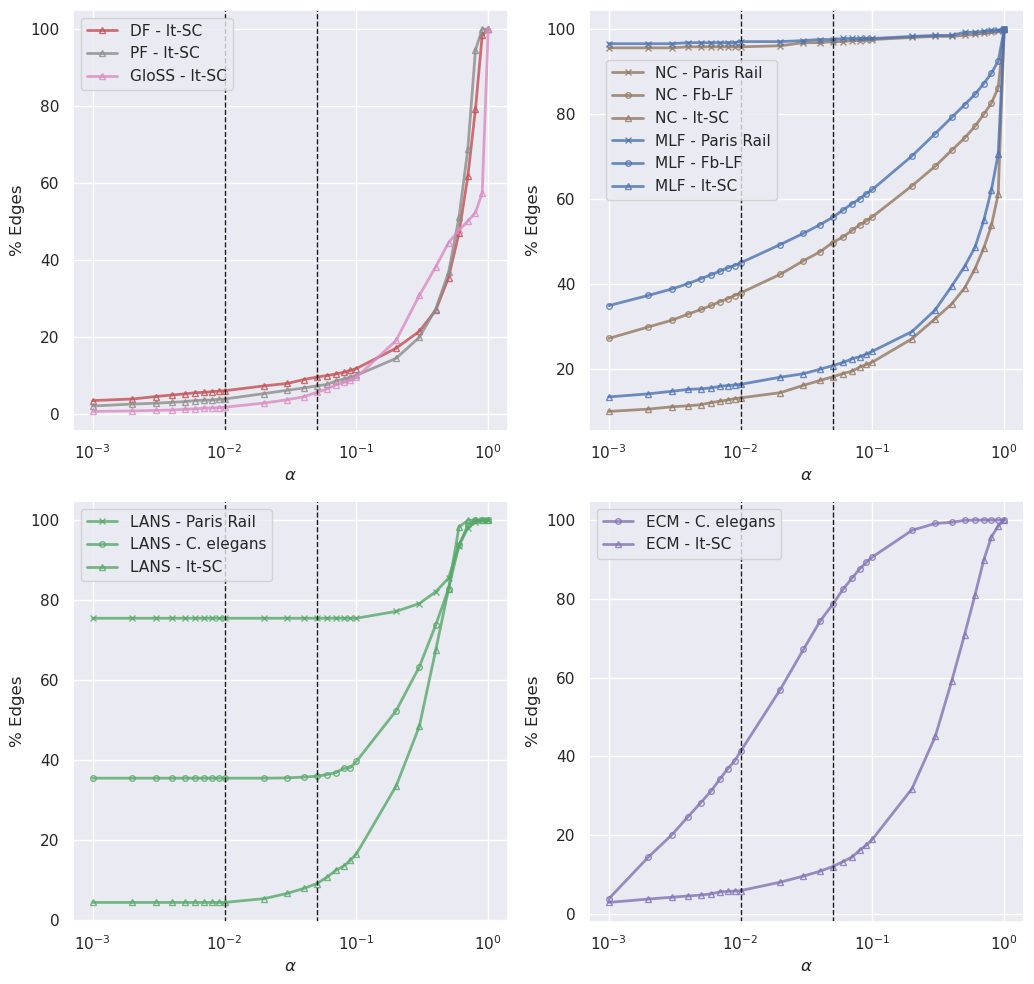

In [6]:
sns.set(font_scale = 1)

sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(10.5,10))

data_directory_in_str = '/mnt/c/Users/Yassin/Desktop/Code/Backbones Survey 2022/Backbone Results/All/'


#############################################################################################################################
               
res3 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')

E3 = res3.shape[0]
        
    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Paris Rail', 'C. elegans', 'It-SC']) 
for name in ['df_alpha', 'pf_alpha', 'gloss_alpha']:
    for alpha in significane_levels:
        backbone3 = res3[['source', 'target', 'weight', name]]
        if 'alpha' in name:
            if alpha == 1:
                backbone3 = backbone3[backbone3[name] <= alpha]
            else:
                backbone3 = backbone3[backbone3[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                else:
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
  
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
    
        backbone_analysis[alpha]['It-SC'] = len(b3.edges())*100/E3

    axs[0,0].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)


axs[0,0].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[0,0].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[0,0].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[0,0].set_ylabel('% Edges')#,fontsize=15)

axs[0,0].set_xscale('log')    
axs[0,0].legend()

############################################################################################################################# 
res1 = pd.read_csv(data_directory_in_str + 'paris_rail.csv')
res2 = pd.read_csv(data_directory_in_str + 'facebook-like-forum.csv')
res3 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')

E1 = res1.shape[0]
E2 = res2.shape[0]
E3 = res3.shape[0]
        
    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Paris Rail', 'Facebook Like Forum', 'It-SC']) 
for name in ['nc_alpha', 'mlf_score']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
    
        backbone_analysis[alpha]['Paris Rail'] = len(b1.edges())*100/E1
        backbone_analysis[alpha]['Facebook Like Forum'] = len(b2.edges())*100/E2
        backbone_analysis[alpha]['It-SC'] = len(b3.edges())*100/E3

    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['Paris Rail'], label=labels[name] + ' - ' + 'Paris Rail', color=colors[name], alpha=0.8, marker='x', markersize=4, linewidth=2, markerfacecolor="None")
    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['Facebook Like Forum'], label=labels[name] + ' - ' + 'Fb-LF', color=colors[name], alpha=0.8, marker='o', markersize=4, linewidth=2, markerfacecolor="None")
    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='^', markersize=4, linewidth=2, markerfacecolor="None")


axs[0,1].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[0,1].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[0,1].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[0,1].set_ylabel('% Edges')#,fontsize=15)

axs[0,1].set_xscale('log')    
axs[0,1].legend(bbox_to_anchor=(0.45, 0.9), loc="upper right")

#############################################################################################################################
        
res1 = pd.read_csv(data_directory_in_str + 'paris_rail.csv')
res2 = pd.read_csv(data_directory_in_str + 'hermaphrodite_gap_junction.csv')
res3 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')

E1 = res1.shape[0]
E2 = res2.shape[0]
E3 = res3.shape[0]
        
    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Paris Rail', 'C. elegans', 'It-SC']) 
for name in ['lans_alpha']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
    
        backbone_analysis[alpha]['Paris Rail'] = len(b1.edges())*100/E1
        backbone_analysis[alpha]['C. elegans'] = len(b2.edges())*100/E2
        backbone_analysis[alpha]['It-SC'] = len(b3.edges())*100/E3

    axs[1,0].plot(backbone_analysis.columns, backbone_analysis.T['Paris Rail'], label=labels[name] + ' - ' + 'Paris Rail', color=colors[name], alpha=0.8, marker='x', markersize=4, linewidth=2, markerfacecolor="None")
    axs[1,0].plot(backbone_analysis.columns, backbone_analysis.T['C. elegans'], label=labels[name] + ' - ' + 'C. elegans', color=colors[name], alpha=0.8, marker='o', markersize=4, linewidth=2, markerfacecolor="None")
    axs[1,0].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='^', markersize=4, linewidth=2, markerfacecolor="None")




axs[1,0].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[1,0].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[1,0].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[1,0].set_ylabel('% Edges')#,fontsize=15)

axs[1,0].set_xscale('log')    
axs[1,0].legend()

#############################################################################################################################
        
res2 = pd.read_csv(data_directory_in_str + 'hermaphrodite_gap_junction.csv')
res3 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')

E2 = res2.shape[0]
E3 = res3.shape[0]
        
    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Paris Rail', 'C. elegans', 'It-SC']) 
for name in ['ecm_alpha']:
    for alpha in significane_levels:
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        if 'alpha' in name:
            if alpha == 1:
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
            else:
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                else:
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
  
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
    
        backbone_analysis[alpha]['C. elegans'] = len(b2.edges())*100/E2
        backbone_analysis[alpha]['It-SC'] = len(b3.edges())*100/E3

    axs[1,1].plot(backbone_analysis.columns, backbone_analysis.T['C. elegans'], label=labels[name] + ' - ' + 'C. elegans', color=colors[name], alpha=0.8, marker='o', markersize=4, linewidth=2, markerfacecolor="None")
    axs[1,1].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='^', markersize=4, linewidth=2, markerfacecolor="None")


axs[1,1].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[1,1].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[1,1].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[1,1].set_ylabel('% Edges')#,fontsize=15)

axs[1,1].set_xscale('log')    
axs[1,1].legend()

#############################################################################################################################





plt.tight_layout()
fig.savefig(figures_path + '% Edges.eps', dpi=300)
fig.savefig(figures_path + '% Edges.png', dpi=300)

# plt.close()
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


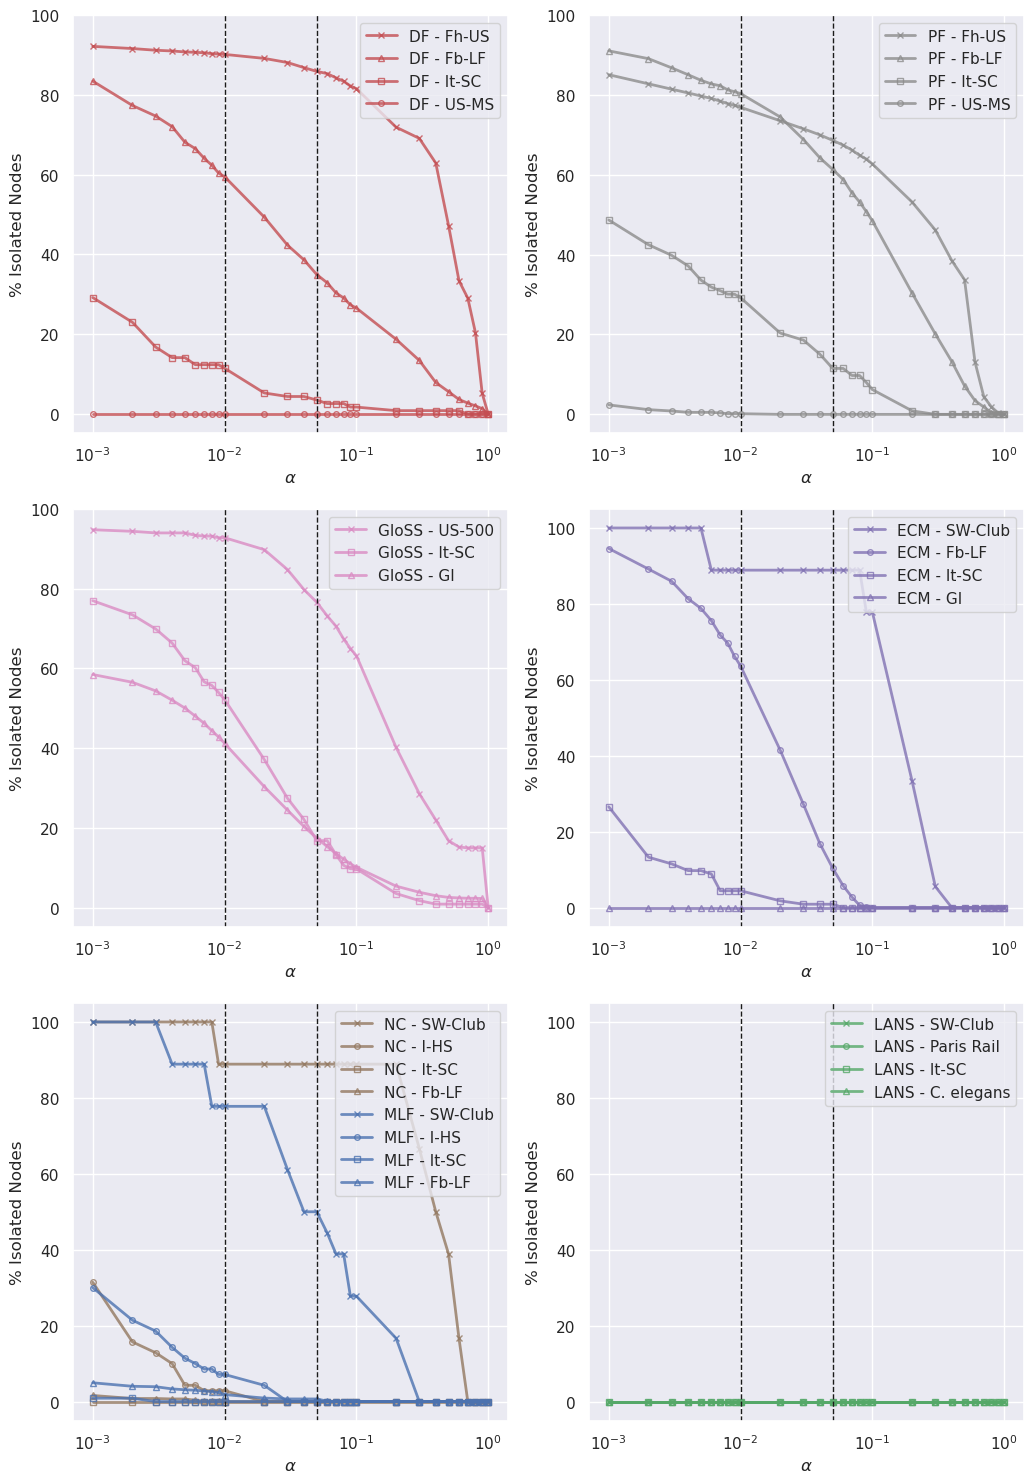

In [7]:
sns.set(font_scale = 1)

sns.set_theme()
fig, axs = plt.subplots(3, 2, figsize=(10.5,15))

data_directory_in_str = '/mnt/c/Users/Yassin/Desktop/Code/Backbones Survey 2022/Backbone Results/All/'


#############################################################################################################################
      
res1 = pd.read_csv(data_directory_in_str + 'academia.csv')
res2 = pd.read_csv(data_directory_in_str + 'facebook-like-forum.csv')
res3 = pd.read_csv(data_directory_in_str + 'toth-middle-school.csv')
res4 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')

N1 = len(list(set(set(res1['source']) | set(res1['target']))))
N2 = len(list(set(set(res2['source']) | set(res2['target']))))
N3 = len(list(set(set(res3['source']) | set(res3['target']))))
N4 = len(list(set(set(res4['source']) | set(res4['target']))))

    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Fh-US', 'Fb-LF', 'US-MS', 'It-SC']) 


for name in ['df_alpha']:#, 'pf_alpha', 'gloss_alpha']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        backbone4 = res4[['source', 'target', 'weight', name]]
        
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
                backbone4 = backbone4[backbone4[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
                backbone4 = backbone4[backbone4[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
        b4 = nx.from_pandas_edgelist(backbone4, edge_attr='weight')

        backbone_analysis[alpha]['Fh-US'] = 100 - len(b1)*100/N1
        backbone_analysis[alpha]['Fb-LF'] = 100 - len(b2)*100/N2
        backbone_analysis[alpha]['US-MS'] = 100 - len(b3)*100/N3
        backbone_analysis[alpha]['It-SC'] = 100 - len(b4)*100/N4

    axs[0,0].plot(backbone_analysis.columns, backbone_analysis.T['Fh-US'], label=labels[name] + ' - ' + 'Fh-US', color=colors[name], alpha=0.8, marker='x',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[0,0].plot(backbone_analysis.columns, backbone_analysis.T['Fb-LF'], label=labels[name] + ' - ' + 'Fb-LF', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[0,0].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='s',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[0,0].plot(backbone_analysis.columns, backbone_analysis.T['US-MS'], label=labels[name] + ' - ' + 'US-MS', color=colors[name], alpha=0.8, marker='o',  markerfacecolor="None", markersize=4, linewidth=2)


axs[0,0].set_yticks(np.arange(0, 120, step=20))
    
axs[0,0].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[0,0].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[0,0].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[0,0].set_ylabel('% Isolated Nodes')#,fontsize=15)

axs[0,0].set_xscale('log')    
axs[0,0].legend()
axs[0,0].legend(bbox_to_anchor=(1, 1), loc="upper right")

############################################################################################################################# 
 

res1 = pd.read_csv(data_directory_in_str + 'academia.csv')
res2 = pd.read_csv(data_directory_in_str + 'facebook-like-forum.csv')
res3 = pd.read_csv(data_directory_in_str + 'toth-middle-school.csv')
res4 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')

N1 = len(list(set(set(res1['source']) | set(res1['target']))))
N2 = len(list(set(set(res2['source']) | set(res2['target']))))
N3 = len(list(set(set(res3['source']) | set(res3['target']))))
N4 = len(list(set(set(res4['source']) | set(res4['target']))))

    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Fh-US', 'Fb-LF', 'US-MS', 'It-SC']) 


for name in ['pf_alpha']:#, 'pf_alpha', 'gloss_alpha']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        backbone4 = res4[['source', 'target', 'weight', name]]
        
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
                backbone4 = backbone4[backbone4[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
                backbone4 = backbone4[backbone4[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
        b4 = nx.from_pandas_edgelist(backbone4, edge_attr='weight')

        backbone_analysis[alpha]['Fh-US'] = 100 - len(b1)*100/N1
        backbone_analysis[alpha]['Fb-LF'] = 100 - len(b2)*100/N2
        backbone_analysis[alpha]['US-MS'] = 100 - len(b3)*100/N3
        backbone_analysis[alpha]['It-SC'] = 100 - len(b4)*100/N4

    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['Fh-US'], label=labels[name] + ' - ' + 'Fh-US', color=colors[name], alpha=0.8, marker='x',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['Fb-LF'], label=labels[name] + ' - ' + 'Fb-LF', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='s',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[0,1].plot(backbone_analysis.columns, backbone_analysis.T['US-MS'], label=labels[name] + ' - ' + 'US-MS', color=colors[name], alpha=0.8, marker='o',  markerfacecolor="None", markersize=4, linewidth=2)


axs[0,1].set_yticks(np.arange(0, 120, step=20))
    
axs[0,1].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[0,1].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[0,1].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[0,1].set_ylabel('% Isolated Nodes')#,fontsize=15)

axs[0,1].set_xscale('log')    
axs[0,1].legend()
# axs[0,0].legend(bbox_to_anchor=(1, 1), loc="upper right")

#############################################################################################################################

res1 = pd.read_csv(data_directory_in_str + 'us-airports-500.csv')
res2 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')
res3 = pd.read_csv(data_directory_in_str + 'gene interactions.csv')

N1 = len(list(set(set(res1['source']) | set(res1['target']))))
N2 = len(list(set(set(res2['source']) | set(res2['target']))))
N3 = len(list(set(set(res3['source']) | set(res3['target']))))

    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['US-500','It-SC', 'GI']) 


for name in ['gloss_alpha']:#, 'pf_alpha', 'gloss_alpha']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')

        backbone_analysis[alpha]['US-500'] = 100 - len(b1)*100/N1
        backbone_analysis[alpha]['It-SC'] = 100 - len(b2)*100/N2
        backbone_analysis[alpha]['GI'] = 100 - len(b3)*100/N3

    axs[1,0].plot(backbone_analysis.columns, backbone_analysis.T['US-500'], label=labels[name] + ' - ' + 'US-500', color=colors[name], alpha=0.8, marker='x',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[1,0].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='s',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[1,0].plot(backbone_analysis.columns, backbone_analysis.T['GI'], label=labels[name] + ' - ' + 'GI', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)


axs[1,0].set_yticks(np.arange(0, 120, step=20))
    
axs[1,0].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[1,0].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[1,0].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[1,0].set_ylabel('% Isolated Nodes')#,fontsize=15)

axs[1,0].set_xscale('log')    
axs[1,0].legend()
# axs[0,0].legend(bbox_to_anchor=(1, 1), loc="upper right")

#############################################################################################################################

res1 = pd.read_csv(data_directory_in_str + 'facebook-like-forum.csv')
res2 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')
res3 = pd.read_csv(data_directory_in_str + 'gene interactions.csv')
res4 = pd.read_csv(data_directory_in_str + 'southern_club_women.csv')


N1 = len(list(set(set(res1['source']) | set(res1['target']))))
N2 = len(list(set(set(res2['source']) | set(res2['target']))))
N3 = len(list(set(set(res3['source']) | set(res3['target']))))
N4 = len(list(set(set(res4['source']) | set(res4['target']))))

    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Fb-LF','It-SC', 'GI', 'SW-Club']) 


for name in ['ecm_alpha']:#, 'pf_alpha', 'gloss_alpha']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        backbone4 = res4[['source', 'target', 'weight', name]]
        
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
                backbone4 = backbone4[backbone4[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
                backbone4 = backbone4[backbone4[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
        b4 = nx.from_pandas_edgelist(backbone4, edge_attr='weight')

        backbone_analysis[alpha]['Fb-LF'] = 100 - len(b1)*100/N1
        backbone_analysis[alpha]['It-SC'] = 100 - len(b2)*100/N2
        backbone_analysis[alpha]['GI'] = 100 - len(b3)*100/N3
        backbone_analysis[alpha]['SW-Club'] = 100 - len(b4)*100/N4

    x = backbone_analysis.T['SW-Club'] 
    axs[1,1].plot(backbone_analysis.columns, backbone_analysis.T['SW-Club'], label=labels[name] + ' - ' + 'SW-Club', color=colors[name], alpha=0.8, marker='x',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[1,1].plot(backbone_analysis.columns, backbone_analysis.T['Fb-LF'], label=labels[name] + ' - ' + 'Fb-LF', color=colors[name], alpha=0.8, marker='o',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[1,1].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='s',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[1,1].plot(backbone_analysis.columns, backbone_analysis.T['GI'], label=labels[name] + ' - ' + 'GI', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)


axs[1,1].set_yticks(np.arange(0, 120, step=20))
    
axs[1,1].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[1,1].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[1,1].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[1,1].set_ylabel('% Isolated Nodes')#,fontsize=15)

axs[1,1].set_xscale('log')    
# axs[1,1].legend()
axs[1,1].legend(bbox_to_anchor=(1, 1), loc="upper right")


#############################################################################################################################

res1 = pd.read_csv(data_directory_in_str + 'highschool.csv')
res2 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')
res3 = pd.read_csv(data_directory_in_str + 'facebook-like-forum.csv')
res4 = pd.read_csv(data_directory_in_str + 'southern_club_women.csv')


N1 = len(list(set(set(res1['source']) | set(res1['target']))))
N2 = len(list(set(set(res2['source']) | set(res2['target']))))
N3 = len(list(set(set(res3['source']) | set(res3['target']))))
N4 = len(list(set(set(res4['source']) | set(res4['target']))))

    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['I-HS','It-SC', 'Fb-LF', 'SW-Club']) 


for name in ['nc_alpha', 'mlf_score']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        backbone4 = res4[['source', 'target', 'weight', name]]
        
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
                backbone4 = backbone4[backbone4[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
                backbone4 = backbone4[backbone4[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
        b4 = nx.from_pandas_edgelist(backbone4, edge_attr='weight')

        backbone_analysis[alpha]['I-HS'] = 100 - len(b1)*100/N1
        backbone_analysis[alpha]['It-SC'] = 100 - len(b2)*100/N2
        backbone_analysis[alpha]['Fb-LF'] = 100 - len(b3)*100/N3
        backbone_analysis[alpha]['SW-Club'] = 100 - len(b4)*100/N4
    

    axs[2,0].plot(backbone_analysis.columns, backbone_analysis.T['SW-Club'], label=labels[name] + ' - ' + 'SW-Club', color=colors[name], alpha=0.8, marker='x',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,0].plot(backbone_analysis.columns, backbone_analysis.T['I-HS'], label=labels[name] + ' - ' + 'I-HS', color=colors[name], alpha=0.8, marker='o',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,0].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='s',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,0].plot(backbone_analysis.columns, backbone_analysis.T['Fb-LF'], label=labels[name] + ' - ' + 'Fb-LF', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)


axs[2,0].set_yticks(np.arange(0, 120, step=20))
    
axs[2,0].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[2,0].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[2,0].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[2,0].set_ylabel('% Isolated Nodes')#,fontsize=15)

axs[2,0].set_xscale('log')    
# axs[2,0].legend()
axs[2,0].legend(bbox_to_anchor=(1, 1), loc="upper right")


#############################################################################################################################

res1 = pd.read_csv(data_directory_in_str + 'paris_rail.csv')
res2 = pd.read_csv(data_directory_in_str + 'sociopatterns-conference.csv')
res3 = pd.read_csv(data_directory_in_str + 'hermaphrodite_gap_junction.csv')
res4 = pd.read_csv(data_directory_in_str + 'southern_club_women.csv')


N1 = len(list(set(set(res1['source']) | set(res1['target']))))
N2 = len(list(set(set(res2['source']) | set(res2['target']))))
N3 = len(list(set(set(res3['source']) | set(res3['target']))))
N4 = len(list(set(set(res4['source']) | set(res4['target']))))

    
backbone_analysis  = pd.DataFrame(columns=significane_levels, index=['Paris Rail','It-SC', 'C. elegans', 'SW-Club']) 


for name in ['lans_alpha']:
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        backbone2 = res2[['source', 'target', 'weight', name]]
        backbone3 = res3[['source', 'target', 'weight', name]]
        backbone4 = res4[['source', 'target', 'weight', name]]
        
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
                backbone2 = backbone2[backbone2[name] <= alpha]
                backbone3 = backbone3[backbone3[name] <= alpha]
                backbone4 = backbone4[backbone4[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
                backbone2 = backbone2[backbone2[name] < alpha]
                backbone3 = backbone3[backbone3[name] < alpha]
                backbone4 = backbone4[backbone4[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] >= -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] >= -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
                    backbone2 = backbone2[backbone2[name] > -np.log(alpha)]
                    backbone3 = backbone3[backbone3[name] > -np.log(alpha)]
                    backbone4 = backbone4[backbone4[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        b2 = nx.from_pandas_edgelist(backbone2, edge_attr='weight')
        b3 = nx.from_pandas_edgelist(backbone3, edge_attr='weight')
        b4 = nx.from_pandas_edgelist(backbone4, edge_attr='weight')

        backbone_analysis[alpha]['Paris Rail'] = 100 - len(b1)*100/N1
        backbone_analysis[alpha]['It-SC'] = 100 - len(b2)*100/N2
        backbone_analysis[alpha]['C. elegans'] = 100 - len(b3)*100/N3
        backbone_analysis[alpha]['SW-Club'] = 100 - len(b4)*100/N4

    axs[2,1].plot(backbone_analysis.columns, backbone_analysis.T['SW-Club'], label=labels[name] + ' - ' + 'SW-Club', color=colors[name], alpha=0.8, marker='x',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,1].plot(backbone_analysis.columns, backbone_analysis.T['Paris Rail'], label=labels[name] + ' - ' + 'Paris Rail', color=colors[name], alpha=0.8, marker='o',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,1].plot(backbone_analysis.columns, backbone_analysis.T['It-SC'], label=labels[name] + ' - ' + 'It-SC', color=colors[name], alpha=0.8, marker='s',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,1].plot(backbone_analysis.columns, backbone_analysis.T['C. elegans'], label=labels[name] + ' - ' + 'C. elegans', color=colors[name], alpha=0.8, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)
    axs[2,1].plot(backbone_analysis.columns, x, color=colors[name], alpha=0, marker='^',  markerfacecolor="None", markersize=4, linewidth=2)


axs[2,1].set_yticks(np.arange(0, 120, step=20))
    
axs[2,1].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[2,1].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)


axs[2,1].set_xlabel(r'$\alpha$')#,fontsize=18)
axs[2,1].set_ylabel('% Isolated Nodes')#,fontsize=15)

axs[2,1].set_xscale('log')    
axs[2,1].legend()
axs[2,1].legend(bbox_to_anchor=(1, 1), loc="upper right")


plt.tight_layout()
fig.savefig(figures_path + '% Isolated Nodes.eps', dpi=300)
fig.savefig(figures_path + '% Isolated Nodes.png', dpi=300)
# plt.close()
    

# Weight fraction behaviors

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


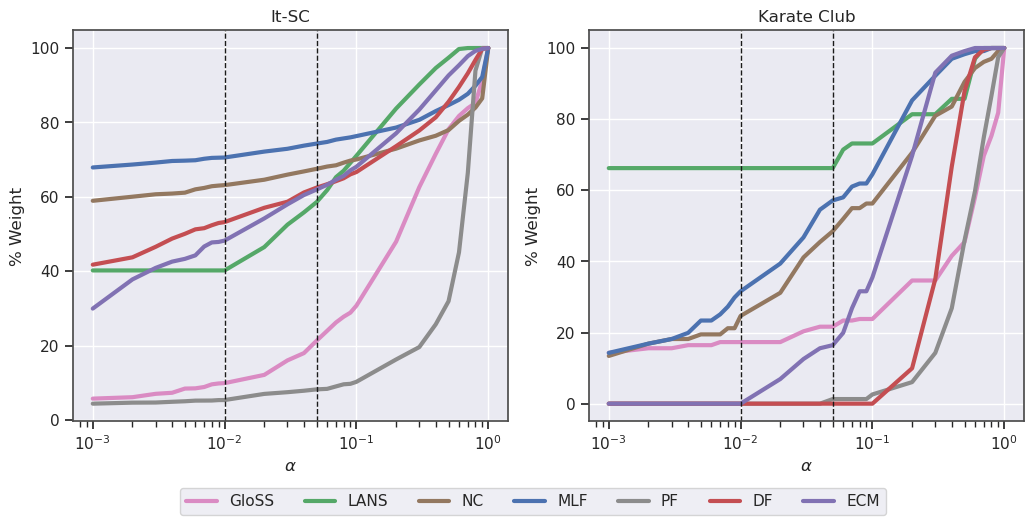

In [55]:
sns.set(font_scale = 1)

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(10.5,5))

data_directory_in_str = '/mnt/c/Users/Yassin/Desktop/Code/Backbones Survey 2022/Backbone Results/All/'


#############################################################################################################################
      
network = 'sociopatterns-conference.csv'

axs[0].tick_params(axis='x', which="both", bottom=True)
axs[0].tick_params(axis='y', which="both", left=True)



res1 = pd.read_csv(data_directory_in_str + network)

W = res1['weight'].sum()
backbones = ['gloss_alpha', 'lans_alpha','nc_alpha', 'mlf_score', 'pf_alpha', 'df_alpha', 'ecm_alpha']



backbone_analysis  = pd.DataFrame(index=significane_levels) 
for backbone in backbones:
    if ((res1[backbone] == 0).all()):
        res1 = res1.drop(columns=[backbone])
        
res1 = res1.drop(columns=['weighted_betweenness', 'betweenness'])

for name in backbones:
    vals = []
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        vals.append(sum(ev.get_weights(b1))*100/W)
    backbone_analysis[name] = vals    


sns.set_palette([colors[name] for name in backbones])
backbone_analysis.columns = [labels[label] for label in backbone_analysis.columns if label !='weight']

g = sns.lineplot(data=backbone_analysis, ax = axs[0], linewidth =3, dashes=False, legend=False)
   




axs[0].spines['bottom'].set_color('0.3')
axs[0].spines['top'].set_color('0.3')
axs[0].spines['right'].set_color('0.3')
axs[0].spines['left'].set_color('0.3')


axs[0].set_xlabel(r'$\alpha$')#, fontsize=12)
axs[0].set_ylabel('% Weight')#, fontsize=12)
axs[0].set_title(network_names[network.split('.')[0]])  
# axs[2,1].set_yticks(np.arange(0, 120, step=20))
    
axs[0].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[0].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)

g.set_xscale('log') 
        
        
# leg1 = axs[0].legend()

############################################################################################################################# 
network = 'karate_club.csv'
      

axs[1].tick_params(axis='x', which="both", bottom=True)
axs[1].tick_params(axis='y', which="both", left=True)



res1 = pd.read_csv(data_directory_in_str + network)

W = res1['weight'].sum()
backbones = ['gloss_alpha', 'lans_alpha','nc_alpha', 'mlf_score', 'pf_alpha', 'df_alpha', 'ecm_alpha']



backbone_analysis  = pd.DataFrame(index=significane_levels) 
for backbone in backbones:
    if ((res1[backbone] == 0).all()):
        res1 = res1.drop(columns=[backbone])
        
res1 = res1.drop(columns=['weighted_betweenness', 'betweenness'])

for name in backbones:
    vals = []
    for alpha in significane_levels:
        backbone1 = res1[['source', 'target', 'weight', name]]
        if 'alpha' in name:
            if alpha == 1:
                backbone1 = backbone1[backbone1[name] <= alpha]
            else:
                backbone1 = backbone1[backbone1[name] < alpha]
        elif 'mlf' in name:
                if alpha == 1:
                    backbone1 = backbone1[backbone1[name] >= -np.log(alpha)]
                else:
                    backbone1 = backbone1[backbone1[name] > -np.log(alpha)]
  
        b1 = nx.from_pandas_edgelist(backbone1, edge_attr='weight')
        vals.append(sum(ev.get_weights(b1))*100/W)
    backbone_analysis[name] = vals    


sns.set_palette([colors[name] for name in backbones])
backbone_analysis.columns = [labels[label] for label in backbone_analysis.columns if label !='weight']

g = sns.lineplot(data=backbone_analysis, ax = axs[1], linewidth =3, dashes=False)
   




axs[1].spines['bottom'].set_color('0.3')
axs[1].spines['top'].set_color('0.3')
axs[1].spines['right'].set_color('0.3')
axs[1].spines['left'].set_color('0.3')


axs[1].set_xlabel(r'$\alpha$')#, fontsize=12)
axs[1].set_ylabel('% Weight')#, fontsize=12)
axs[1].set_title(network_names[network.split('.')[0]])  
# axs[2,1].set_yticks(np.arange(0, 120, step=20))
    
axs[1].axvline(x = 10**-2, color = 'k', linestyle='--', linewidth=1)
axs[1].axvline(x = 10**-2*5, color = 'k', linestyle='--', linewidth=1)

g.set_xscale('log') 
        
        
# leg2 = axs[1].legend()


#############################################################################################################################


plt.tight_layout()
lgd = plt.legend(bbox_to_anchor=(0.7, -0.15), ncol=7)
for legobj in lgd.legendHandles:
    legobj.set_linewidth(3)
fig.savefig(figures_path + '% Weights.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
fig.savefig(figures_path + '% Weights.eps', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
# # plt.close()
    